# Data Wrangling with The Office 🖨️👨🏻‍💼

John Fiocca

Here's a script I wrote to scrape and wrangle all the screenplays of _The Office_ from <https://www.officequotes.net>.

An incomplete list of the challenges:
- Scraping the web.
- RegEx to match natural language transcription.
    - Faulty encoding.
    - Missing data.
    - Inconsistent conventions.
- Tidying loose, natural-language data into tabular format.

## Programming

### Imports

In [1]:
from pathlib import Path
import re
from urllib.parse import urljoin

import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import requests
import pandas as pd

### Defining wrangling functions

#### Collecting all the episode detail pages.

In [2]:
def scrape_episode_urls(home_page=r"https://www.officequotes.net"):
    """Scrape the episode pages from the links in the homepage's sidebar."""

    r = requests.get(home_page)

    # requests did not default to utf-8 as declared in the page header, so resetting here.
    r.encoding = "utf-8"

    soup = BeautifulSoup(r.text)
    episode_paths = [
        a.get("href")
        for a in soup.find(id="sidebar-left").find_all("a")
        if re.match(r"/no\d+-\d+.html", a.get("href"))
    ]

    episode_urls = map(lambda path: urljoin(home_page, path), episode_paths)

    return episode_urls

### Regular Expressions

Good luck trying to get ChatGPT to write this for you.

This is as tough as data wrangling gets; nothing like having your sales reps type the promo name in the Salesforce comment box as an improvised flag for an A/B test.

In [3]:
def _extract_episode_metadata(episode_page):
    """Scrape the episode's metadata from the page source.

    Args:
        episode_page (str): The page source for the episode. Best retrieved using BeautifulSoup.

    Returns:
        dict: A dictionary of the episode's metadata: Season, Episode Number, Title, Writing Credit, and Directing Credit.
    """
    p = re.compile(
        r"""(?sx)
        Season\s(?P<Season>\d).*
        Episode\s(?P<Episode>\d+).*
        ["“”](?P<Title>[\w \.\-'’?,,()]*)["“”].*           # Need to include some special characters in the titles: -, ', ’, ?, ,, ,, (yes these are different commas.)
        Written\sby:?\s(?P<WrittenBy>[\w ,\.&()]*).*       # I've noticed the pattern can also end with a double space.
        Directed\sby\s(?P<Director>[\w ,\.&]*)\s{2,}
        """
    )
    s = re.search(p, episode_page.find("main").text)

    cleaned_metadata = {k: str.strip(v) for k, v in s.groupdict().items()}

    return cleaned_metadata

In [4]:
def compare_pages(index):
    """Utility function for development to compare the page text for composing a RegEx pattern."""
    r = requests.get(episode_urls_list[index])
    r.encoding = "utf-8"

    soup = BeautifulSoup(r.text)

    return soup

### Remaining Processing Functions

In [5]:
def extract_script(episode_page, include_deleted_scenes=False):
    """Extract the script from the episode's page.

    Args:
        episode_page (str): The page source for the episode. Best retrieved using BeautifulSoup.
        include_deleted_scenes (bool): Include deleted scenes? Defaults to False.

    Returns:
        DataFrame: Each row is a scene from the episode.
    """

    episode_metadata = _extract_episode_metadata(episode_page)

    scenes = enumerate(
        [
            str.strip(scene.text)
            for scene in episode_page.find("main").find_all("div", class_="quote")
        ]
    )
    df = pd.DataFrame.from_records(scenes, columns=["SceneNumber", "Dialogue"]).assign(
        IsDeletedScene=lambda df: df.Dialogue.str.match(r"Deleted Scene"),
        **episode_metadata,
    )

    if include_deleted_scenes == False:
        df = df.query("~IsDeletedScene")

    return df

In [6]:
def _convert_dialogue_to_cued_speeches(dialogue_string):
    """Helper function to pair the character cue with his speech in the dialogue.

    Args:
        dialogue_string (str): The complete dialogue of the scene with its character cues.

    Returns:
        list: A list of paired character cues and speeches.
    """
    p = re.compile(r"(?P<Character>[\w ]+):")
    lines = [str.strip(line) for line in p.split(dialogue_string) if line != r""]
    pair_player_and_line = zip(lines[::2], lines[1::2])
    return list(pair_player_and_line)

In [7]:
def character_speeches(episode_df):
    """Breakout individual speeches for each character from within the dialogue.

    Args:
        episode_df (DataFrame): DataFrame of the episode's script.

    Returns:
        DataFrame: The provided dataframe with dialogue exploded to cues and speeches.
    """
    df = (
        episode_df.assign(
            Lines=lambda x: x.Dialogue.apply(_convert_dialogue_to_cued_speeches)
        )
        .explode("Lines")
        .reset_index()
        .assign(
            Character=lambda x: x.Lines.apply(pd.Series)[0],
            Speech=lambda x: x.Lines.apply(pd.Series)[1],
        )
    )
    return df

### Main Program

In [8]:
def main(episode_urls):

    screenplay_frames = []

    # Extract some metadata for the episode.
    for episode_url in episode_urls:

        try:
            r = requests.get(episode_url)
            r.encoding = "utf-8"  # requests did not default to utf-8 as declared in the page header, so resetting here.

            soup = BeautifulSoup(r.text)
            episode_df = extract_script(soup).pipe(character_speeches)

            screenplay_frames.append(episode_df)
        except:
            print(f'"{episode_url}" appears to be corrupted.')
            continue

    complete_screenplays_of_the_office = pd.concat(screenplay_frames)

    return complete_screenplays_of_the_office

## Run the main program to collect our scripts.

In [9]:
from pathlib import Path

storage_path = "../data/the-office-screenplays.csv"

if Path(storage_path).exists():
    complete_works = pd.read_csv(storage_path)
else:
    # Remaining corruptions are a missing fields, missing quotes on titles, and missing transcriptions.
    complete_works = main(episode_urls=scrape_episode_urls())
    complete_works.to_csv("../data/the-office-screenplays.csv", index=False)

## Quick Querying

In [10]:
complete_works.filter(['Season', 'Episode', 'Title', 'Character', 'Speech'])

,Season,Episode,Title,Character,Speech
0,1,1,Pilot,Michael,All right Jim. Your quarterlies look very good...
1,1,1,Pilot,Jim,"Oh, I told you. I couldn't close it. So..."
2,1,1,Pilot,Michael,So you've come to the master for guidance? Is ...
3,1,1,Pilot,Jim,"Actually, you called me in here, but yeah."
4,1,1,Pilot,Michael,"All right. Well, let me show you how it's done."
...,...,...,...,...,...
56577,9,23,Finale,Creed,It all seems so very arbitrary. I applied for ...
56578,9,23,Finale,Meredith,I just feel lucky that I got a chance to share...
56579,9,23,Finale,Phyllis,I’m happy that this was all filmed so I can re...
56580,9,23,Finale,Jim,I sold paper at this company for 12 years. My ...


#### Toby wrote some good episodes for himself.

In [11]:
written_by_toby = complete_works.query('WrittenBy.str.contains("Paul Lieberstein")')[['Season', 'Episode', 'Title', 'WrittenBy']].drop_duplicates().reset_index(drop=True)
written_by_toby

,Season,Episode,Title,WrittenBy
0,1,3,Health Care,Paul Lieberstein
1,2,7,The Client,Paul Lieberstein
2,2,14,The Carpet,Paul Lieberstein
3,2,17,Dwight's Speech,Paul Lieberstein
4,3,3,The Coup,Paul Lieberstein
5,3,23,The Job,Paul Lieberstein & Michael Schur
6,4,4,Money,Paul Lieberstein
7,4,14,Goodbye Toby,Paul Lieberstein
8,5,13,Stress Relief,Paul Lieberstein
9,6,1,Gossip,Paul Lieberstein


In [12]:
top_30_characters = (
    complete_works.groupby("Character")["Speech"].count().sort_values().tail(30).index
)
top_30_characters_speeches_by_season = (
    complete_works[complete_works.Character.isin(top_30_characters)]
    .pivot_table(
        "Speech", index="Character", columns="Season", aggfunc="count", margins=True
    )
    .sort_values(by="All", ascending=False)
)
top_30_characters_speech_distribution_over_series = (
    top_30_characters_speeches_by_season.apply(
        lambda x: x / top_30_characters_speeches_by_season["All"]
    )
)
top_30_characters_speech_distribution_by_season = (
    top_30_characters_speeches_by_season.apply(
        lambda x: x / top_30_characters_speeches_by_season.loc["All"], axis=1
    )
)

In [13]:
top_30_characters_speeches_by_season

Season,1,2,3,4,5,6,7,8,9,All
Character,,,,,,,,,,
All,1345.0,5453.0,6906.0,4499.0,7107.0,6830.0,6342.0,6063.0,5756.0,50301
Michael,470.0,1870.0,1978.0,1401.0,2018.0,1968.0,1339.0,NaN,2.0,11046
Dwight,213.0,838.0,939.0,471.0,993.0,792.0,660.0,901.0,991.0,6798
Jim,229.0,751.0,773.0,629.0,789.0,913.0,676.0,817.0,703.0,6280
Pam,170.0,621.0,645.0,463.0,626.0,703.0,607.0,456.0,680.0,4971
Andy,NaN,NaN,389.0,208.0,462.0,538.0,514.0,1078.0,604.0,3793
Kevin,22.0,124.0,208.0,123.0,164.0,224.0,228.0,239.0,251.0,1583
Angela,23.0,138.0,239.0,165.0,200.0,127.0,156.0,163.0,364.0,1575
Erin,NaN,NaN,NaN,NaN,53.0,300.0,306.0,402.0,352.0,1413


## Visual Exploration.

In [14]:
import seaborn as sns

sns.set_theme()
sns.set_palette("viridis")
%matplotlib inline

Text(0.5, 1.0, 'Top 10 Characters in "The Office" by Speech Count')

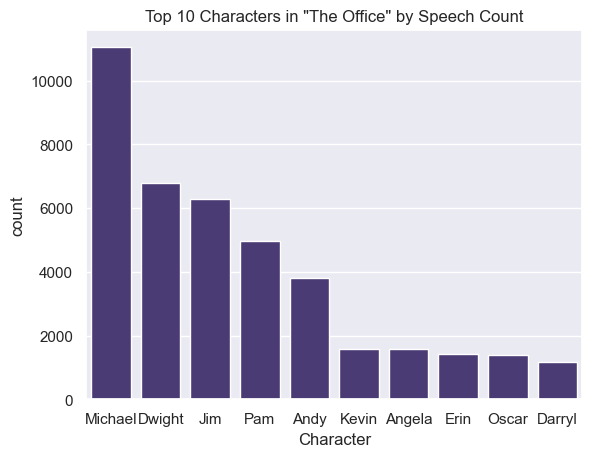

In [15]:
ax = sns.barplot(complete_works.Character.value_counts().head(10))
ax.set_title('Top 10 Characters in "The Office" by Speech Count')

In [16]:
def plot_heatmap(df, title, n_head, **kwargs):
    ax = sns.heatmap(
        df.head(n_head).drop("All").drop(columns="All"),
        cmap="viridis",
        **kwargs,
    )
    ax.set_title(title)

## A quick discovery that true fans already know:

The writers elevated the minor characters in season 8 to fill the void left by Michael, diluting the manager's (Andy's) importance.

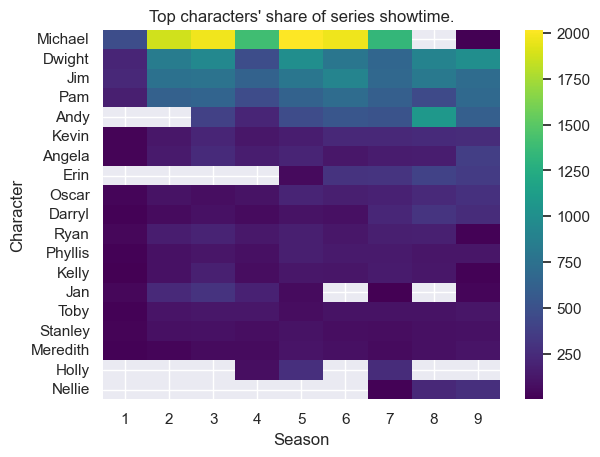

In [17]:
plot_heatmap(
    top_30_characters_speeches_by_season,
    f"Top characters' share of series showtime.",
    20,
)

While Andy had the most screentime of any character in season 8...

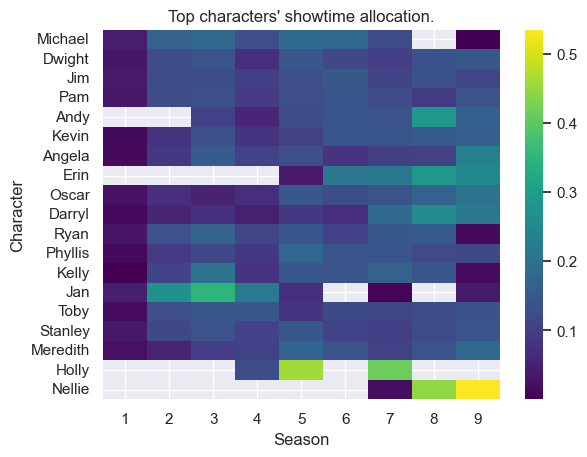

In [18]:
plot_heatmap(
    top_30_characters_speech_distribution_over_series,
    f"Top characters' showtime allocation.",
    20,
)

...his stint as manager didn't dominate the show like Michael's did.

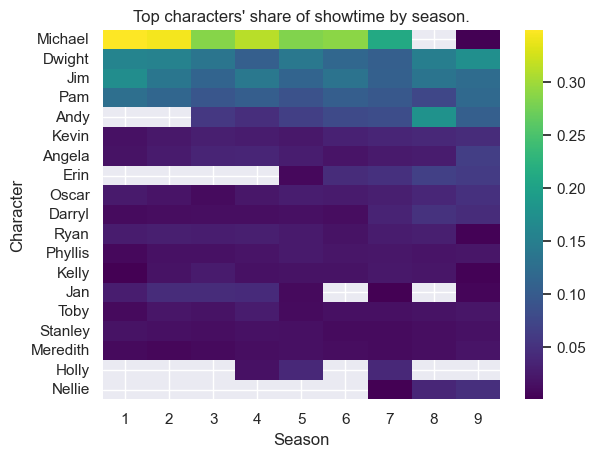

In [19]:
plot_heatmap(
    top_30_characters_speech_distribution_by_season,
    f"Top characters' share of showtime by season.",
    20,
)

## Next Steps

- Speech length, not just count.
- Do writers have favorite characters?
- Monologues, dialogues, set pieces, and soliloquies.